In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np
import os

In [2]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [3]:
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

In [4]:
def load(file_name):
    """
    Gvien the file name, open the image and return PIL format image
    """
    image_dir = "../flickr_datasets/flickr30k_images"
    pil_image = Image.open(os.path.join(image_dir,file_name))
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()

In [5]:
"""
RPN
    POST_NMS_TOP_N_TRAIN    2000
    POST_NMS_TOP_N_TEST     1000
    NMS_THRESH              0.7

ROI_HEAD
    NMS                     0.5
    DETECTIONS_PER_IMG      100

"""
config_file = "../configs/e2e_faster_rcnn_R_50_C4_1x.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cuda"])




In [6]:

coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
    weight_loading="../pretrained_models/e2e_faster_rcnn_R_50_C4_1x.pth"
)

Loading weight from ../pretrained_models/e2e_faster_rcnn_R_50_C4_1x.pth.


Num of Proposal before object confidence filtering: 12


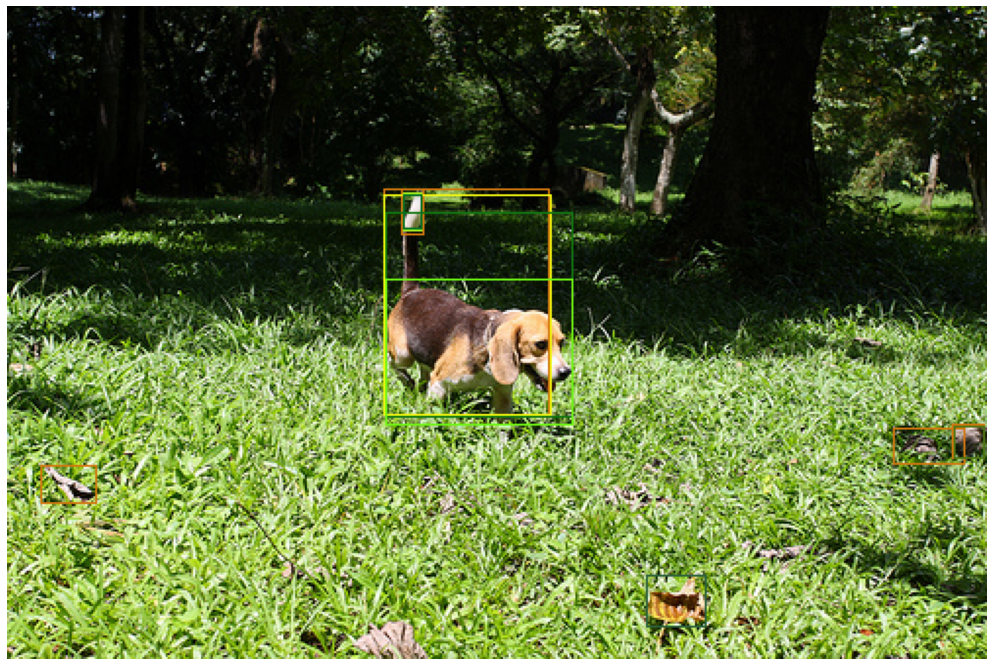

In [7]:
image = load(os.listdir( "../flickr_datasets/flickr30k_images")[0])

predictions = coco_demo.run_on_opencv_image(image, os.listdir( "../flickr_datasets/flickr30k_images")[0])
imshow(predictions)

In [9]:
# compute predictions
image_list = os.listdir( "../flickr_datasets/flickr30k_images")[:10]
for image_file in image_list:
    image = load(image_file)
    predictions = coco_demo.run_on_opencv_image(image,image_file)


Num of Proposal before object confidence filtering: 12
Num of Proposal before object confidence filtering: 100
Num of Proposal before object confidence filtering: 32
Num of Proposal before object confidence filtering: 18
Num of Proposal before object confidence filtering: 18
Num of Proposal before object confidence filtering: 99
Num of Proposal before object confidence filtering: 17
Num of Proposal before object confidence filtering: 100
Num of Proposal before object confidence filtering: 100
Num of Proposal before object confidence filtering: 100


In [12]:
with open('/home/zhangjiacheng/Code/maskrcnn-benchmark/flickr_datasets/split/train_backpack.txt','r') as f:
    image_file_list = f.readlines()
    print(len(image_file_list))
    print(image_file_list[0].strip()+'.jpg')

29783
3359636318.jpg


In [10]:
# check the generated proposals
feat_dir = "../flickr_datasets/flickr30k_feat_nms"
feat_file_list = os.listdir(feat_dir)


In [33]:
import os.path as osp
import pickle
import torch
def get_precompute_img_feat(img_id):

    with open(osp.join('../flickr_datasets/flickr30k_feat_nms/{}.pkl'.format(img_id)), 'rb') as load_f:
        res = pickle.load(load_f)

    feature_map = torch.FloatTensor(res['features'])  ## 1*1024*h*w ## feature map in res4
    precompute_bbox = res['boxes'][:, :4]
    img_scale = res['img_scale']  ## value to denote the image scale
    cls_scores = res['boxes'][:, 4]  ## (N,) denote the detection score
    cls_label = res['boxes'][:, 5] - 1 ## for MSCOCO 0~80
    cls_label = cls_label.astype(np.int32)

    return None, feature_map, precompute_bbox, img_scale, cls_scores, cls_label

def overlay_boxes(image, boxes):

    for box in boxes:
        box = box.astype(np.int64)
        top_left, bottom_right = box[:2].tolist(), box[2:].tolist()
        image = cv2.rectangle(
            image, tuple(top_left), tuple(bottom_right), (255,0,255), 3
        )

    return image

Image size: (334, 500, 3)


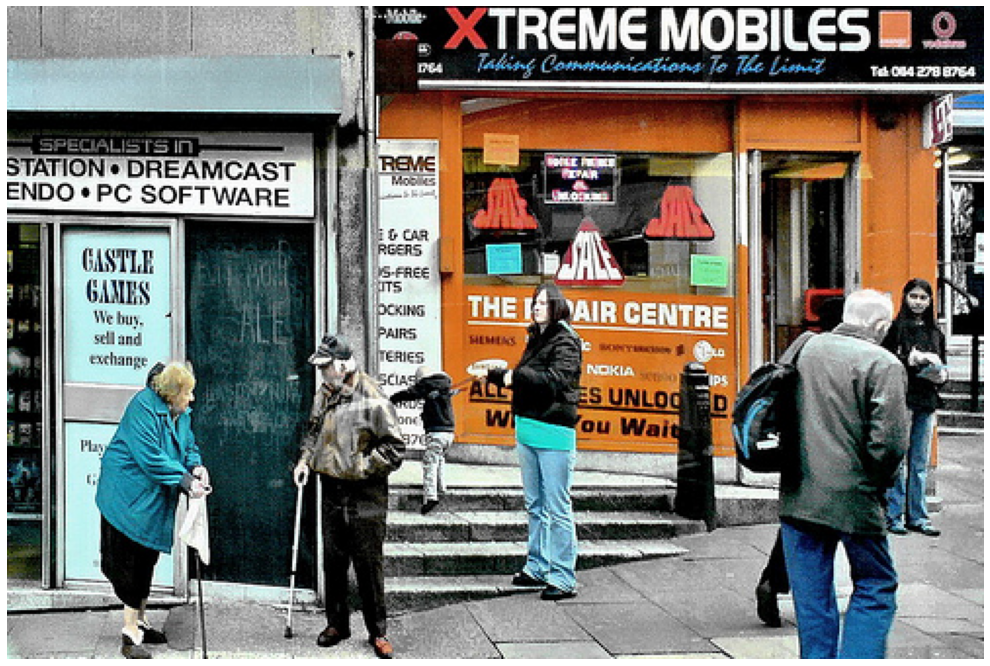

In [36]:
image_id = image_file_list[0].strip()

# load image
image_file = image_id + '.jpg'
image = load(image_file)
print("Image size:",image.shape)
imshow(image)

In [37]:
# load feat
_, feature_map, precompute_bbox, img_scale, precompute_score, cls_label = get_precompute_img_feat(image_id)
print("Feature Map:",feature_map.shape)
print("Precompute Box:",precompute_bbox.shape)
print("Image Scale:",img_scale)


Feature Map: torch.Size([1, 1024, 50, 75])
Precompute Box: (63, 4)
Image Scale: (1197, 800)


(800, 1197, 3)


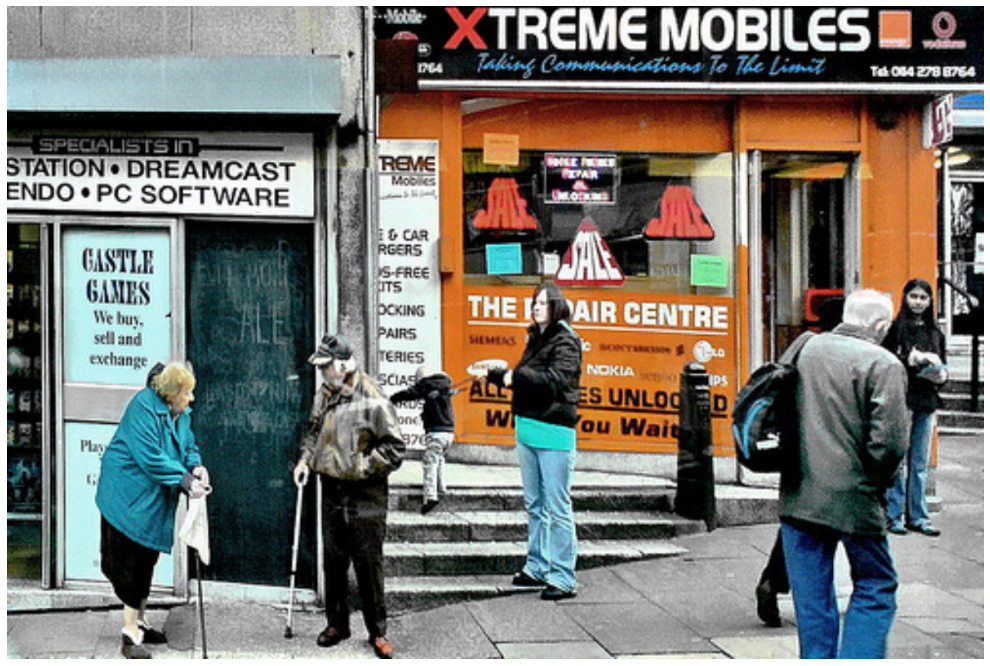

In [38]:
# show the precompute box
import cv2
image_resize = cv2.resize(image,img_scale)
print(image_resize.shape)
imshow(image_resize)


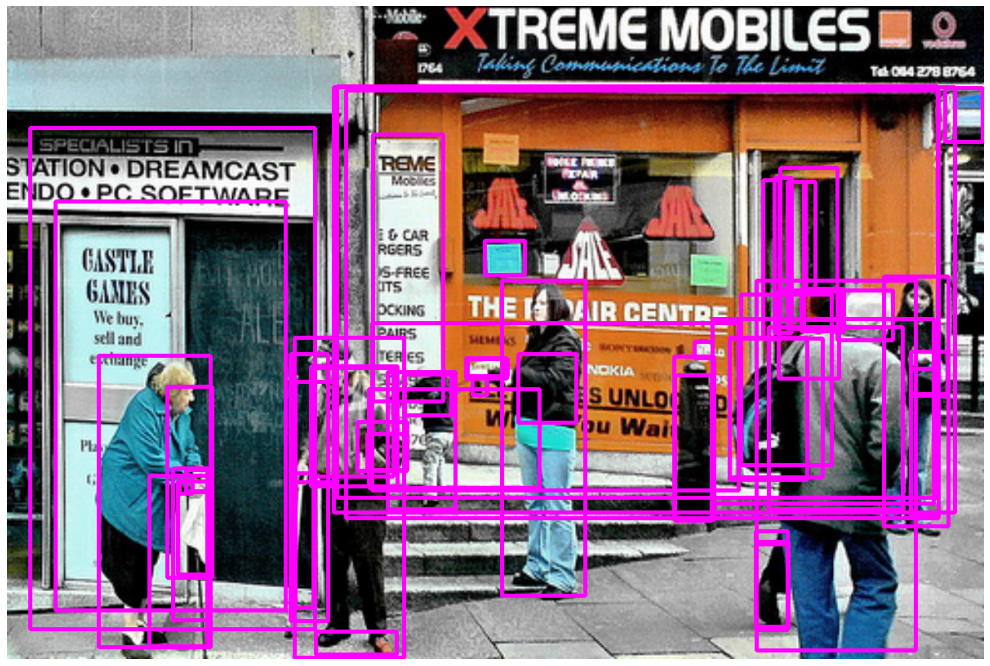

In [39]:
draw_boxes  = overlay_boxes(image_resize,precompute_bbox)
imshow(draw_boxes)